# Hindcast 2019-05 Jun-Aug anomalies

This notebook contains the processing code to plot hindcast 2019-05 anomalies over the 2015-2019 record.

***

In [12]:
import cmocean.cm as cm
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
#from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar

%matplotlib inline

In [25]:
plt.rcParams.update({'font.size': 16, 'axes.titlesize': 'medium'})

***

### Processing

Load fields from monthly averages

In [148]:
# Load monthly averages
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
slc = {'y': slice(334, 790), 'x': slice(114, 390)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['salinity', 'nitrate', 'diatoms', 'ciliates', 'flagellates', 'PPDIAT', 'PPMRUB', 'PPPHY',
                                      'GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ', 'GRMICZDIAT', 'GRMICZMRUB', 'GRMICZPHY', 'GRMICZPON']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in years:
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(6, 9):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
        # Load salinity
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            data['salinity'].append(ds.vosaline.isel(deptht=0, **slc).values)
        
        # Load ecosystem variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
            for var in ['diatoms', 'ciliates', 'flagellates']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
        
        with xr.open_dataset(prefix + '_prod_T.nc') as ds:
            for var in ['PPDIAT', 'PPMRUB', 'PPPHY']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
            
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
            for var in ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ', 'GRMICZDIAT', 'GRMICZMRUB', 'GRMICZPHY', 'GRMICZPON']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Add chlorophyll fields
aggregates['chlorophyll'] = {}
variables.append('chlorophyll')
for year in years:
    aggregates['chlorophyll'][year] = sum(aggregates[var][year] for var in ['diatoms', 'ciliates', 'flagellates'])
    
# Add PP fields
aggregates['PP'] = {}
variables.append('PP')
for year in years:
    aggregates['PP'][year] = sum(aggregates[var][year] for var in ['PPDIAT', 'PPMRUB', 'PPPHY'])
    
# Add SP fields
aggregates['SP'] = {}
variables.append('SP')
for year in years:
    aggregates['SP'][year] = 0.3*sum(aggregates[var][year] for var in ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMICZDIAT', 'GRMICZMRUB', 'GRMICZPHY', 'GRMICZPON'])
    
# Calculate 5 year mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

Load HRDPS wind

In [6]:
# Load wind from pre-aggregated .nc file
HRDPS = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/HRDPS_1h_20141201_20200201_wind.nc')
time = HRDPS.time.values.astype('datetime64[s]').astype(datetime)
windmask = HRDPS.landmask.values
u, v = [HRDPS[var].values for var in ('u_wind', 'v_wind')]
wspd = np.sqrt(u**2 + v**2)

# Compiles summer averages
aggregates['wspd'] = {}
for year in years:
    index = (time > datetime(year, 6, 1)) & (time < datetime(year, 9, 1))
    aggregates['wspd'][year] = wspd[index].mean(axis=0)

# Find 5 year mean and yearly anomalies
aggregates['wspd']['mean'] = np.concatenate([aggregates['wspd'][year][None, ...] for year in years]).mean(axis=0)
for year in years: aggregates['wspd'][year] = aggregates['wspd'][year] - aggregates['wspd']['mean']

Reset some variables for plotting

In [149]:
# Reset variables for plotting
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
tmask = tmask[0, 0, ...]
variables = ['wspd', 'salinity', 'nitrate', 'diatoms', 'chlorophyll']
print (tmask.shape)

(456, 276)


***

### Plotting

Plot seasonal averages

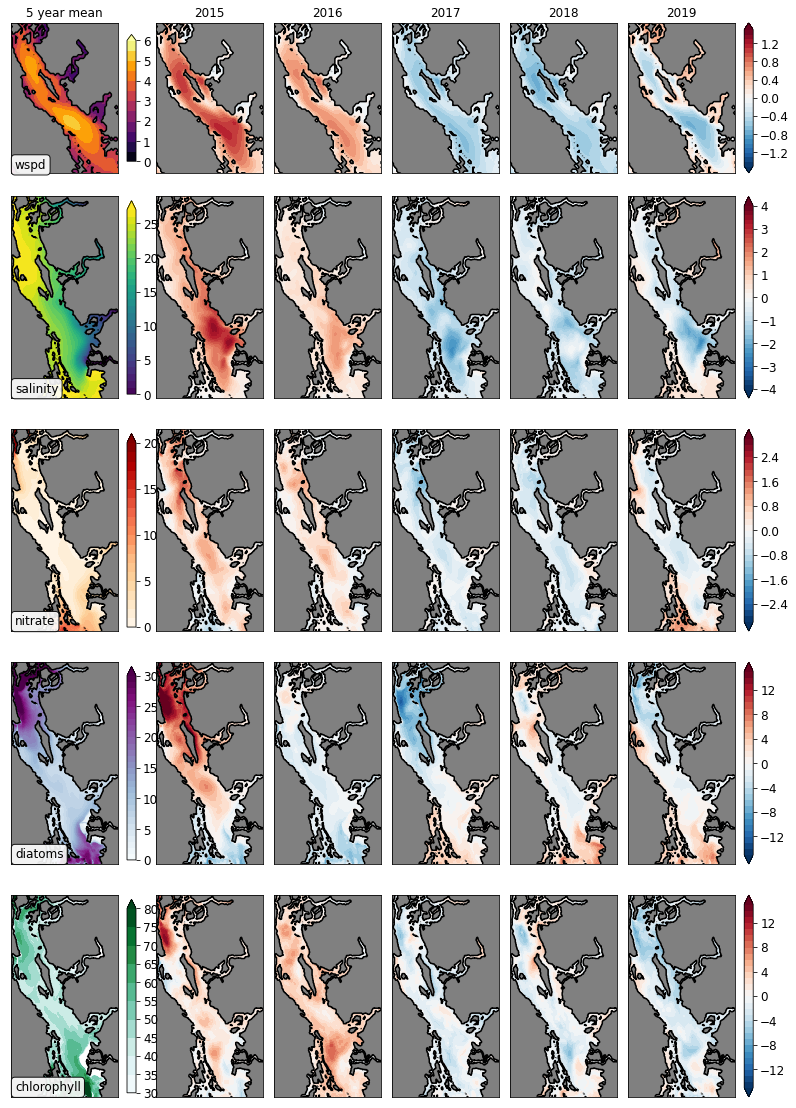

In [8]:
gridspec_kw = {'height_ratios': [0.7, 1, 1, 1, 1], 'wspace': 0.1, 'hspace': 0.05}
fig, axs = plt.subplots(5, 6, figsize=(12.5, 20), gridspec_kw=gridspec_kw)

cmaps = ['inferno', 'viridis', 'OrRd', 'BuPu', 'BuGn']
clims = [(0, 6.1, 0.5), (0, 28, 1), (0, 21, 1), (0, 30.1, 1), (30, 80.1, 5)]
dclims = [(-1.5, 1.6, 0.1), (-4, 4.1, 0.2), (-3, 3.1, 0.2), (-15, 15.1, 1), (-15, 15.1, 1)]
for row, var, cmap, clim, dclim, dcbar in zip(axs, variables, cmaps, clims, dclims, [1, 5, 5, 5, 5]):
    
    c = row[0].contourf(aggregates[var]['mean'], levels=np.arange(*clim), cmap=cmap, extend='max')
    pos = row[0].get_position()
    row[0].set_position([pos.x0-0.03, pos.y0, pos.width, pos.height])
    cax = fig.add_axes([pos.x1-0.02, pos.y0+0.01, 0.01, pos.height-0.02])
    fig.colorbar(c, cax=cax, ticks=range(0, 101, dcbar))
    row[0].text(0.04, 0.03, var, transform=row[0].transAxes, bbox={'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9})
    if var == 'wspd': row[0].set_title('5 year mean', fontsize=12)
    
    for ax, year in zip(row[1:], years):
    
        c = ax.contourf(aggregates[var][year], levels=np.arange(*dclim), cmap='RdBu_r', extend='both')
        if var == 'wspd': ax.set_title(year, fontsize=12)
    
    for ax in row:
        if var == 'wspd':
            landmask = windmask
            ax.set_xlim([5, 70])
            ax.set_ylim([30, 110])
        else:
            landmask = tmask
        ax.contourf(landmask, levels=[-0.01, 0.01], colors='gray')
        ax.contour(landmask, levels=[-0.01, 0.01], colors='k')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_aspect(5/4.4)
    
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+0.01, pos.y0, 0.01, pos.height])
    fig.colorbar(c, cax=cax)

In [9]:
## Plots in Pieces

nitrate 108959.82
chlorophyll 1927271.2690593274


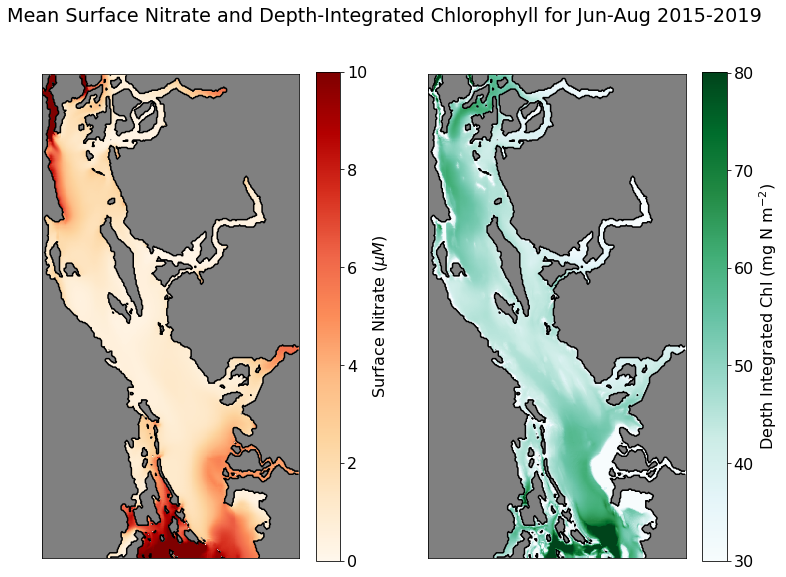

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12.7, 9))
#c = row[0].contourf(aggregates[var]['mean'], levels=np.arange(*clim), cmap=cmap, extend='max')
var = 'nitrate'
cmap = 'OrRd'
clim = [0, 10]
C = axs[0].pcolormesh(aggregates[var]['mean'], vmin=clim[0], vmax=clim[1], cmap=cmap)
cbar = fig.colorbar(C, ax=axs[0])
cbar.set_label('Surface Nitrate ($\mu M$)')
print (var, np.nansum(aggregates[var]['mean']))

var = 'chlorophyll'
cmap = 'BuGn'
clim = [30, 80.1]
C = axs[1].pcolormesh(aggregates[var]['mean'], vmin=clim[0], vmax=clim[1], cmap=cmap)
cbar = fig.colorbar(C, ax=axs[1])
cbar.set_label('Depth Integrated Chl (mg N m$^{-2}$)')
print (var, aggregates[var]['mean'].sum())

for ax in axs:
    landmask = tmask
    ax.contourf(landmask, levels=[-0.01, 0.01], colors='gray')
    ax.contour(landmask, levels=[-0.01, 0.01], colors='k')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect(5/4.4)
    
fig.suptitle('Mean Surface Nitrate and Depth-Integrated Chlorophyll for Jun-Aug 2015-2019');
plt.savefig('meanNChl.png')

nitrate 2015 18668.213 0.17133117
nitrate 2016 9597.78 0.0880855
nitrate 2017 -15054.2 -0.13816285
nitrate 2018 -13407.065 -0.12304596
nitrate 2019 195.27592 0.0017921829
chlorophyll 2015 61824.03577050926 0.032078533397472714
chlorophyll 2016 125287.7943181935 0.06500786699287257
chlorophyll 2017 -62138.51525339079 -0.032241706837522505
chlorophyll 2018 -28380.621344796386 -0.014725805235839242
chlorophyll 2019 -96592.6934905156 -0.05011888831698356
0.11868546667557911
0.03741122826104484


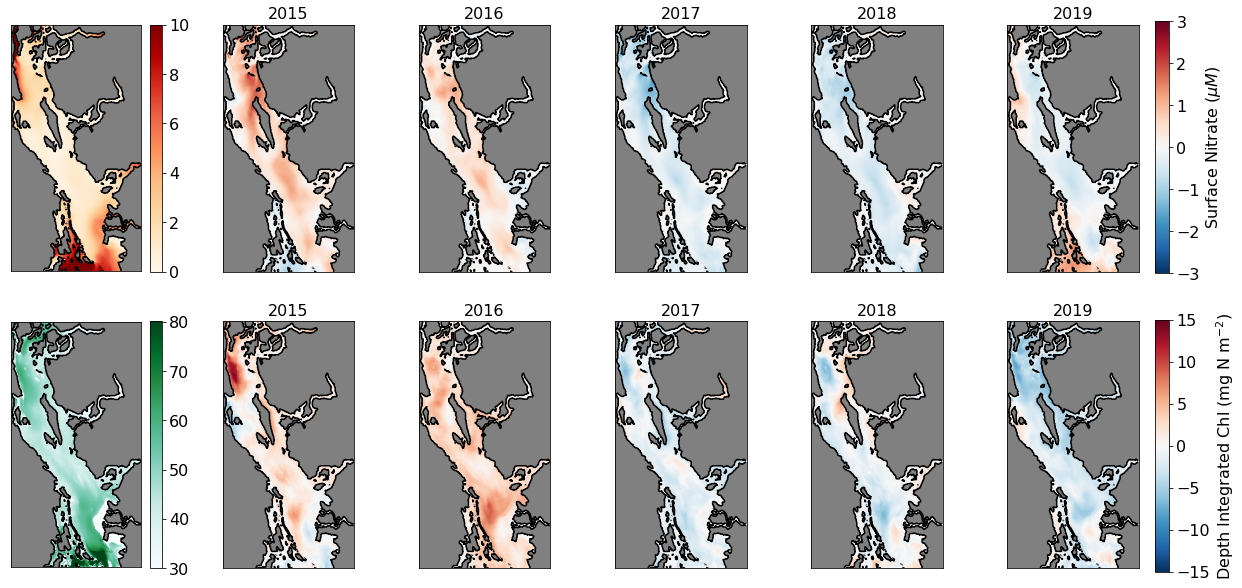

In [92]:
fig, axs = plt.subplots(2, 6, figsize=(20.5, 10))
#c = row[0].contourf(aggregates[var]['mean'], levels=np.arange(*clim), cmap=cmap, extend='max')
var = 'nitrate'
cmap = 'OrRd'
clim = [0, 10]
dlim = 3
C = axs[0, 0].pcolormesh(aggregates[var]['mean'], vmin=clim[0], vmax=clim[1], cmap=cmap)
cbar = fig.colorbar(C, ax=axs[0, 0])


for ax, year in zip(axs[0, 1:], years):
    c = ax.pcolormesh(aggregates[var][year], vmin=-dlim, vmax=dlim, cmap='RdBu_r')
    ax.set_title(year)
    print (var, year, np.nansum(aggregates[var][year]), np.nansum(aggregates[var][year])/np.nansum(aggregates[var]['mean']))
cax = fig.add_axes([0.9, 0.535, 0.01, 0.35])
cbar = fig.colorbar(c, cax=cax)
cbar.set_label('Surface Nitrate ($\mu M$)')


var = 'chlorophyll'
cmap = 'BuGn'
clim = [30, 80.1]
dlim = 15
C = axs[1, 0].pcolormesh(aggregates[var]['mean'], vmin=clim[0], vmax=clim[1], cmap=cmap)
cbar = fig.colorbar(C, ax=axs[1, 0])


for ax, year in zip(axs[1, 1:], years):
    c = ax.pcolormesh(aggregates[var][year], vmin=-dlim, vmax=dlim, cmap='RdBu_r')
    ax.set_title(year)
    print (var, year, np.nansum(aggregates[var][year]), np.nansum(aggregates[var][year])/np.nansum(aggregates[var]['mean']))
cax = fig.add_axes([0.9, 0.12, 0.01, 0.35])
cbar = fig.colorbar(c, cax=cax)
cbar.set_label('Depth Integrated Chl (mg N m$^{-2}$)')

for row in range(2):
    for ax in axs[row, :]:
        landmask = tmask
        ax.contourf(landmask, levels=[-0.01, 0.01], colors='gray')
        ax.contour(landmask, levels=[-0.01, 0.01], colors='k')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_aspect(5/4.4)
    
#fig.suptitle('Mean Surface Nitrate and Depth-Integrated Chlorophyll for Jun-Aug 2015-2019');
#fig.tight_layout()
plt.savefig('NChlvar.png')
print (np.std([0.171, 0.088, -0.138, -0.12, 0.002]))
print (np.std([0.032, 0.065, -0.032, -0.015, 0.050]))

wspd 2015 1908.1426 0.07314125
wspd 2016 1041.592 0.039925393
wspd 2017 -1501.159 -0.057541113
wspd 2018 -2048.8142 -0.07853335
wspd 2019 600.2389 0.02300783
salinity 2015 53114.902 0.05863021
salinity 2016 25130.941 0.02774047
salinity 2017 -37444.42 -0.04133255
salinity 2018 -28052.393 -0.030965276
salinity 2019 -12749.032 -0.014072857
nitrate 2015 18668.213 0.17133117
nitrate 2016 9597.78 0.0880855
nitrate 2017 -15054.2 -0.13816285
nitrate 2018 -13407.065 -0.12304596
nitrate 2019 195.27592 0.0017921829
0.11868546667557911
0.03741122826104484


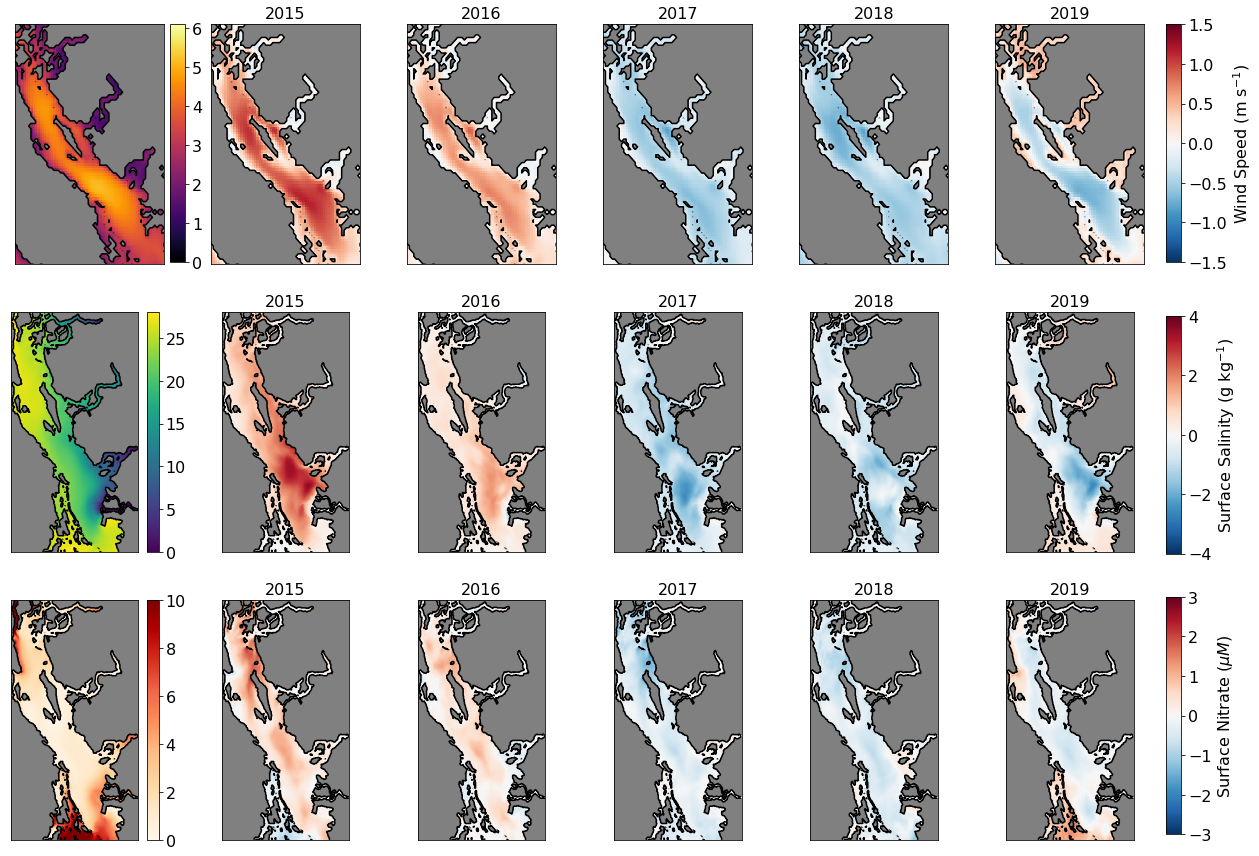

In [110]:
fig, axs = plt.subplots(3, 6, figsize=(20.5, 15))

var = 'wspd'
cmap = 'inferno'
clim = [0, 6.1]
dlim = 1.5
C = axs[0, 0].pcolormesh(aggregates[var]['mean'], vmin=clim[0], vmax=clim[1], cmap=cmap)
cax = fig.add_axes([0.235, 0.66, 0.01, 0.22])
cbar = fig.colorbar(C, cax=cax)

for ax, year in zip(axs[0, 1:], years):
    c = ax.pcolormesh(aggregates[var][year], vmin=-dlim, vmax=dlim, cmap='RdBu_r')
    ax.set_title(year)
    print (var, year, np.nansum(aggregates[var][year]), np.nansum(aggregates[var][year])/np.nansum(aggregates[var]['mean']))
    
cax = fig.add_axes([0.91, 0.66, 0.01, 0.22])
cbar = fig.colorbar(c, cax=cax)
cbar.set_label('Wind Speed (m s$^{-1}$)')

for ax in axs[0, :]:
    landmask = windmask
    ax.set_xlim([5, 70])
    ax.set_ylim([28, 120])
    ax.contourf(landmask, levels=[-0.01, 0.01], colors='gray')
    ax.contour(landmask, levels=[-0.01, 0.01], colors='k')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect(5/4.4)

    
var = 'salinity'
cmap = 'viridis'
clim = [0, 28]
dlim = 4
C = axs[1, 0].pcolormesh(aggregates[var]['mean'], vmin=clim[0], vmax=clim[1], cmap=cmap)
cbar = fig.colorbar(C, ax=axs[1, 0])


for ax, year in zip(axs[1, 1:], years):
    c = ax.pcolormesh(aggregates[var][year], vmin=-dlim, vmax=dlim, cmap='RdBu_r')
    ax.set_title(year)
    print (var, year, np.nansum(aggregates[var][year]), np.nansum(aggregates[var][year])/np.nansum(aggregates[var]['mean']))
cax = fig.add_axes([0.91, 0.39, 0.01, 0.22])
cbar = fig.colorbar(c, cax=cax)
cbar.set_label('Surface Salinity (g kg$^{-1}$)')

var = 'nitrate'
cmap = 'OrRd'
clim = [0, 10]
dlim = 3
C = axs[2, 0].pcolormesh(aggregates[var]['mean'], vmin=clim[0], vmax=clim[1], cmap=cmap)
cbar = fig.colorbar(C, ax=axs[2, 0])


for ax, year in zip(axs[2, 1:], years):
    c = ax.pcolormesh(aggregates[var][year], vmin=-dlim, vmax=dlim, cmap='RdBu_r')
    ax.set_title(year)
    print (var, year, np.nansum(aggregates[var][year]), np.nansum(aggregates[var][year])/np.nansum(aggregates[var]['mean']))
cax = fig.add_axes([0.91, 0.13, 0.01, 0.22])
cbar = fig.colorbar(c, cax=cax)
cbar.set_label('Surface Nitrate ($\mu M$)')




for row in range(1, 3):
    for ax in axs[row, :]:
        landmask = tmask
        ax.contourf(landmask, levels=[-0.01, 0.01], colors='gray')
        ax.contour(landmask, levels=[-0.01, 0.01], colors='k')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_aspect(5/4.4)
    
#fig.suptitle('Mean Surface Nitrate and Depth-Integrated Chlorophyll for Jun-Aug 2015-2019');
#fig.tight_layout()
plt.savefig('WSNvar.png')
print (np.std([0.171, 0.088, -0.138, -0.12, 0.002]))
print (np.std([0.032, 0.065, -0.032, -0.015, 0.050]))

PP 8.700391935482005
PP 2015 0.8545929721669074 0.09822465223453898
PP 2016 0.38970459144197994 0.04479161333556523
PP 2017 -0.4733924940662824 -0.054410479157345724
PP 2018 -0.3602280771586989 -0.04140366087297907
PP 2019 -0.4106769923839063 -0.047202125539779455
SP 3.2029480133590726
SP 2015 0.3418859683582876 0.10674102949293165
SP 2016 0.0980492215351863 0.03061218013100305
SP 2017 -0.19527520165957432 -0.06096733410754945
SP 2018 -0.08025575086038621 -0.025056838426864902
SP 2019 -0.16440423737351334 -0.051329037089520343
0.06057392178157198
0.058842161754986536
0.06222025393712243


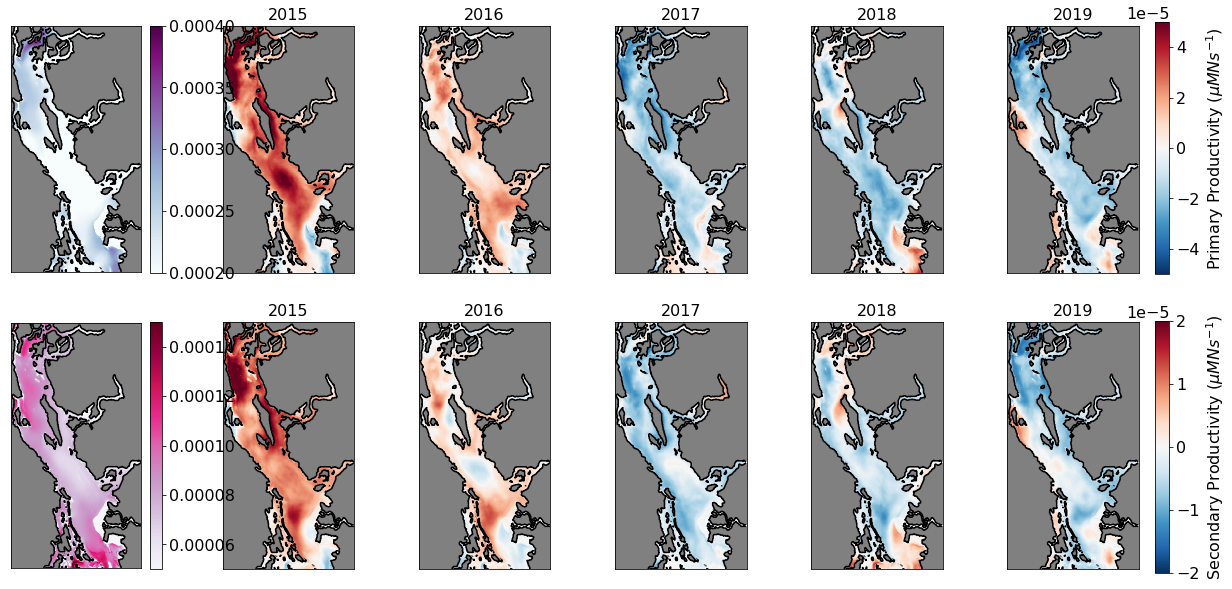

In [152]:
fig, axs = plt.subplots(2, 6, figsize=(20.5, 10))
#c = row[0].contourf(aggregates[var]['mean'], levels=np.arange(*clim), cmap=cmap, extend='max')
var = 'PP'
cmap = 'BuPu'
clim = [2e-4, 4e-4]
dlim = 5e-5
C = axs[0, 0].pcolormesh(aggregates[var]['mean'], vmin=clim[0], vmax=clim[1], cmap=cmap)
cbar = fig.colorbar(C, ax=axs[0, 0])
print (var, np.nansum(aggregates[var]['mean']))


for ax, year in zip(axs[0, 1:], years):
    c = ax.pcolormesh(aggregates[var][year], vmin=-dlim, vmax=dlim, cmap='RdBu_r')
    ax.set_title(year)
    print (var, year, np.nansum(aggregates[var][year]), np.nansum(aggregates[var][year])/np.nansum(aggregates[var]['mean']))
cax = fig.add_axes([0.9, 0.535, 0.01, 0.35])
cbar = fig.colorbar(c, cax=cax)
cbar.set_label('Primary Productivity ($\mu M N s^{-1}$)')


var = 'SP'
cmap = 'PuRd'
clim = [0.5e-4, 1.5e-4]
dlim = 2e-5
C = axs[1, 0].pcolormesh(aggregates[var]['mean'], vmin=clim[0], vmax=clim[1], cmap=cmap)
cbar = fig.colorbar(C, ax=axs[1, 0])
print (var, np.nansum(aggregates[var]['mean']))


for ax, year in zip(axs[1, 1:], years):
    c = ax.pcolormesh(aggregates[var][year], vmin=-dlim, vmax=dlim, cmap='RdBu_r')
    ax.set_title(year)
    print (var, year, np.nansum(aggregates[var][year]), np.nansum(aggregates[var][year])/np.nansum(aggregates[var]['mean']))
cax = fig.add_axes([0.9, 0.12, 0.01, 0.35])
cbar = fig.colorbar(c, cax=cax)
cbar.set_label('Secondary Productivity ($\mu M N s^{-1}$)')

for row in range(2):
    for ax in axs[row, :]:
        landmask = tmask
        ax.contourf(landmask, levels=[-0.01, 0.01], colors='gray')
        ax.contour(landmask, levels=[-0.01, 0.01], colors='k')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_aspect(5/4.4)

plt.savefig('PPSP.png')
print (np.std([0.098, 0.044, -0.054, -0.041, -0.047]))
print (np.std([0.090, 0.050, -0.054, -0.036, -0.050]))
print (np.std([0.107, 0.031, -0.061, -0.025, -0.051]))